In [1]:
from explainers.GNNBoundary.gnn_boundary.models.gcn_classifier import GCNClassifier as GCNClassifier
import torch as torch

In [2]:
import numpy as np

In [3]:

model = GCNClassifier(node_features=3,
                            num_classes=7,
                            hidden_channels=16,
                            num_layers=4)
model.load_state_dict(torch.load('model/report_models/duo.pt'))

<All keys matched successfully>

In [4]:
from graph_generation.DuoSet import DuoSetCreator
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(DuoSetCreator(5000, 50, True ,deterministicClass= True).getDataset())
mean_embeds = dataset.mean_embeddings(model)


In [5]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   0,    3,    9, ..., 4997, 4998, 4999]),
 array([   4,   26,   40,   54,   72,   74,   80,   86,   91,   98,  100,
         103,  107,  121,  122,  131,  133,  140,  158,  179,  192,  193,
         197,  201,  202,  214,  220,  221,  223,  237,  251,  255,  262,
         264,  281,  301,  310,  313,  315,  342,  373,  375,  388,  397,
         403,  404,  410,  423,  441,  444,  448,  462,  471,  506,  508,
         520,  522,  536,  547,  562,  565,  572,  575,  578,  592,  612,
         620,  625,  636,  641,  660,  666,  670,  676,  681,  690,  696,
         698,  710,  712,  715,  731,  748,  769,  772,  782,  783,  784,
         790,  802,  812,  815,  832,  835,  836,  846,  847,  851,  853,
         855,  865,  870,  889,  898,  903,  905,  924,  935,  952,  959,
         965,  966,  977,  987,  992, 1002, 1009, 1016, 1023, 1027, 1029,
        1038, 1044, 1047, 1061, 1092, 1093, 1099, 1104, 1113, 1122, 1132,
        1139, 1161, 1162, 1208, 1212, 1217, 1226, 1227, 1231,

In [6]:
classes

array([0, 1, 2, 3, 4, 5, 6])

In [8]:

trainers = {}

In [60]:
from explainers.gnninterpreter import *
c = 0

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=30,
                num_node_cls=3,
                temperature=0.45,
                learn_node_feat=True
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=20),
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=0, mode='minimize'), weight=50),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=0),
                dict(key="logits", criterion=MeanPenalty(), weight=0),
                dict(key="omega", criterion=NormPenalty(order=1), weight=0),
                dict(key="omega", criterion=NormPenalty(order=2), weight=0),
                dict(key="xi", criterion=NormPenalty(order=1), weight=1),
                dict(key="xi", criterion=NormPenalty(order=2), weight=1),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=32
        )
trainers[c].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=9 m=5
logits=[-1.3859267234802246, -6.395005702972412, -6.955480575561523, -6.891915798187256, -15.904071807861328, -15.970722198486328, -15.344279289245605]
probs=[0.9856553077697754, 0.006581270135939121, 0.003757496364414692, 0.0040040952153503895, 4.881743507212377e-07, 4.566979612263822e-07, 8.544553224965057e-07]


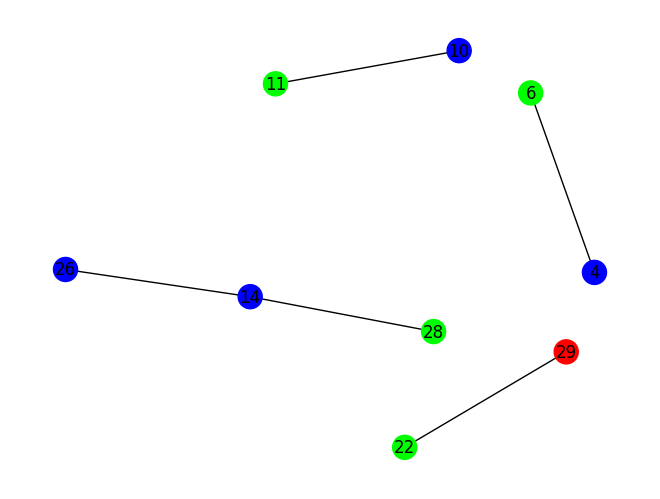

(<networkx.classes.graph.Graph at 0x7f0a38f281c0>,
 {'n': 9,
  'm': 5,
  'logits': [-1.3859267234802246,
   -6.395005702972412,
   -6.955480575561523,
   -6.891915798187256,
   -15.904071807861328,
   -15.970722198486328,
   -15.344279289245605],
  'probs': [0.9856553077697754,
   0.006581270135939121,
   0.003757496364414692,
   0.0040040952153503895,
   4.881743507212377e-07,
   4.566979612263822e-07,
   8.544553224965057e-07]})

In [61]:
trainers[0].evaluate(threshold=0.6, show=True)

n=4 m=2
logits=[-0.6929597854614258, 0.04667513817548752, -2.7105557918548584, -4.180185317993164, -2.667658805847168, -2.550492286682129, -6.357420444488525]
probs=[0.28113120794296265, 0.5890178084373474, 0.03738334774971008, 0.00859856978058815, 0.03902187570929527, 0.04387255385518074, 0.0009746866417117417]


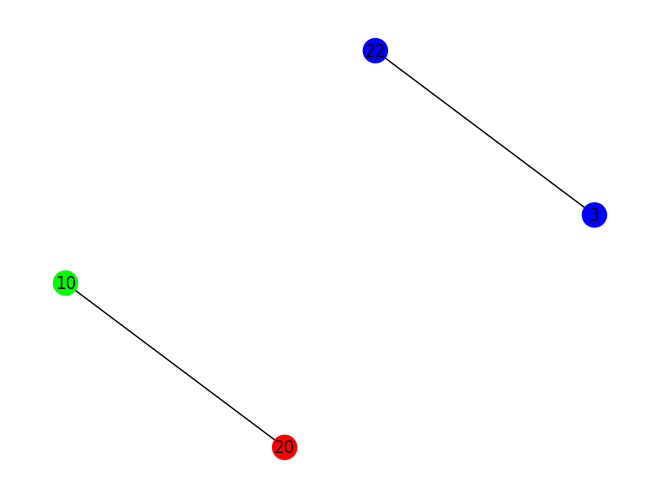

(<networkx.classes.graph.Graph at 0x7f0a35489750>,
 {'n': 4,
  'm': 2,
  'logits': [-0.6929597854614258,
   0.04667513817548752,
   -2.7105557918548584,
   -4.180185317993164,
   -2.667658805847168,
   -2.550492286682129,
   -6.357420444488525],
  'probs': [0.28113120794296265,
   0.5890178084373474,
   0.03738334774971008,
   0.00859856978058815,
   0.03902187570929527,
   0.04387255385518074,
   0.0009746866417117417]})

In [46]:
trainers[1].evaluate(threshold=0.6, show=True)

In [52]:
trainers[2].evaluate(threshold=0.1, show=True)

Exception: Empty graph!

n=4 m=2
logits=[-0.7293493747711182, -3.6412482261657715, -2.6556193828582764, -0.02133053168654442, -5.200273513793945, -3.2543675899505615, -3.115687608718872]
probs=[0.2929554581642151, 0.015928687527775764, 0.04268086329102516, 0.5946894884109497, 0.0033504553139209747, 0.023453092202544212, 0.026941891759634018]


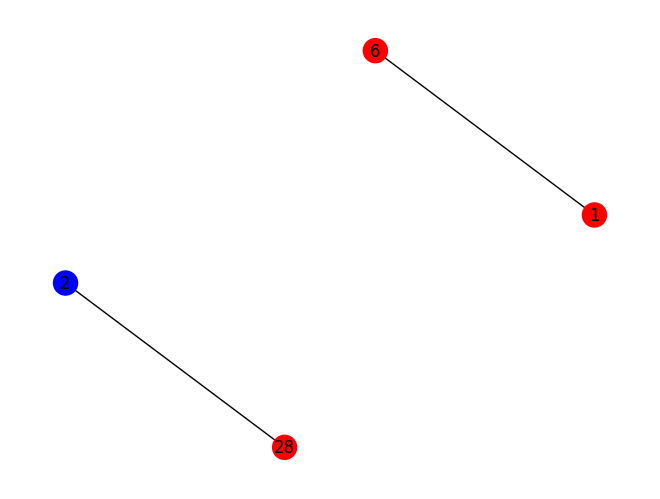

(<networkx.classes.graph.Graph at 0x7f0a2dae4460>,
 {'n': 4,
  'm': 2,
  'logits': [-0.7293493747711182,
   -3.6412482261657715,
   -2.6556193828582764,
   -0.02133053168654442,
   -5.200273513793945,
   -3.2543675899505615,
   -3.115687608718872],
  'probs': [0.2929554581642151,
   0.015928687527775764,
   0.04268086329102516,
   0.5946894884109497,
   0.0033504553139209747,
   0.023453092202544212,
   0.026941891759634018]})

In [53]:
trainers[3].evaluate(threshold=0.6, show=True)

n=2 m=1
logits=[-0.9416800737380981, -3.4736475944519043, -3.1785430908203125, -4.027380466461182, -7.7339253425598145, -8.29883098602295, -8.122035026550293]
probs=[0.8100345134735107, 0.06439971178770065, 0.08650599420070648, 0.037016965448856354, 0.0009092196705751121, 0.0005168129573576152, 0.0006167581886984408]


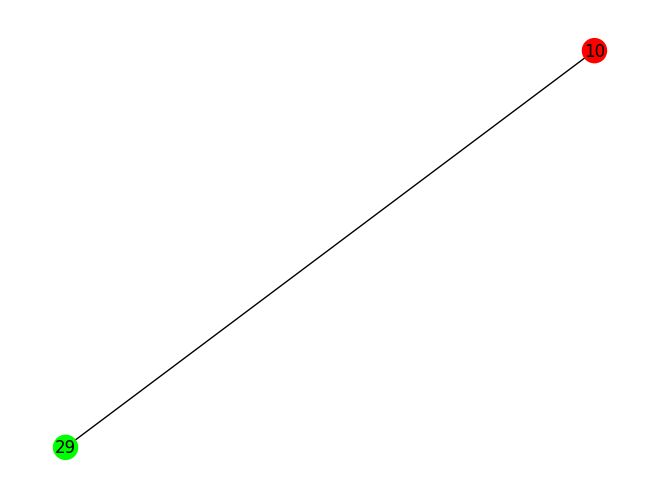

(<networkx.classes.graph.Graph at 0x7f0a2da073a0>,
 {'n': 2,
  'm': 1,
  'logits': [-0.9416800737380981,
   -3.4736475944519043,
   -3.1785430908203125,
   -4.027380466461182,
   -7.7339253425598145,
   -8.29883098602295,
   -8.122035026550293],
  'probs': [0.8100345134735107,
   0.06439971178770065,
   0.08650599420070648,
   0.037016965448856354,
   0.0009092196705751121,
   0.0005168129573576152,
   0.0006167581886984408]})

In [55]:
trainers[4].evaluate(threshold=0.6, show=True)

n=4 m=2
logits=[-0.7293493747711182, -3.6412482261657715, -2.6556193828582764, -0.02133053168654442, -5.200273513793945, -3.2543675899505615, -3.115687608718872]
probs=[0.2929554581642151, 0.015928687527775764, 0.04268086329102516, 0.5946894884109497, 0.0033504553139209747, 0.023453092202544212, 0.026941891759634018]


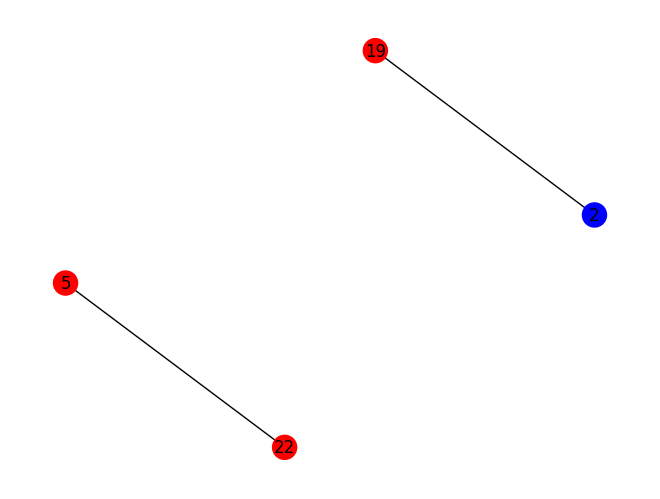

(<networkx.classes.graph.Graph at 0x7f0a3548a200>,
 {'n': 4,
  'm': 2,
  'logits': [-0.7293493747711182,
   -3.6412482261657715,
   -2.6556193828582764,
   -0.02133053168654442,
   -5.200273513793945,
   -3.2543675899505615,
   -3.115687608718872],
  'probs': [0.2929554581642151,
   0.015928687527775764,
   0.04268086329102516,
   0.5946894884109497,
   0.0033504553139209747,
   0.023453092202544212,
   0.026941891759634018]})

In [57]:
trainers[5].evaluate(threshold=0.6, show=True)

n=2 m=1
logits=[-0.9416800737380981, -3.4736475944519043, -3.1785430908203125, -4.027380466461182, -7.7339253425598145, -8.29883098602295, -8.122035026550293]
probs=[0.8100345134735107, 0.06439971178770065, 0.08650599420070648, 0.037016965448856354, 0.0009092196705751121, 0.0005168129573576152, 0.0006167581886984408]


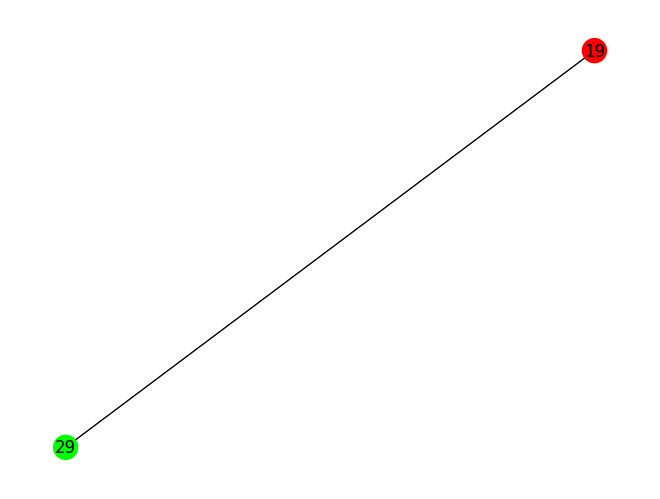

(<networkx.classes.graph.Graph at 0x7f0a38f28670>,
 {'n': 2,
  'm': 1,
  'logits': [-0.9416800737380981,
   -3.4736475944519043,
   -3.1785430908203125,
   -4.027380466461182,
   -7.7339253425598145,
   -8.29883098602295,
   -8.122035026550293],
  'probs': [0.8100345134735107,
   0.06439971178770065,
   0.08650599420070648,
   0.037016965448856354,
   0.0009092196705751121,
   0.0005168129573576152,
   0.0006167581886984408]})

In [64]:
trainers[6].evaluate(threshold=0.6, show=True)